In [1]:
import numpy as np

In [5]:
class GetMiniBatch:
    """
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [22]:
class ScratchSimpleNeuralNetrowkClassifier():
    def __init__(self,
                 batch_size = 20, #number of data
                 n_features = 784, #input size
                 n_nodes1 = 400, # hidden size of first layer 
                 n_nodes2 = 200, # hidden size of second layer 
                 n_output = 10, # 0-9 total 10 numbers
                 sigma = 0.02, # parameter initialize 
                 lr = 0.01, #learning rate 
                 epoch = 10, #iteration 
                 verbose=True):
        
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        self.loss_train = []
        self.loss_val = []

        #parameter initilize
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)
   
    def fit(self, X, y, X_val=None, y_val=None):
        
        for e in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                self.forward(mini_X_train)
                self.backward(mini_X_train, mini_y_train)
                
            self.forward(X)
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            
            if X_val is not None:
                self.forward(X_val)
                self.loss_val.append(self.cross_entropy_error(y_val, self.Z3))
                
            if self.verbose:
                if X_val is None:
                    print(self.loss_train)
                else:
                    print(f"Epoch {e}:", "Train loss:", self.loss_train[-1], "Val loss:", self.loss_val[-1])
    
    def forward(self, X):
        self.A1 = X @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.tanh_function(self.A2)
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)
    
    def backward(self, X, y):
        dA3 = (self.Z3 - y)/self.batch_size
        dW3 = self.Z2.T @ dA3
        dB3 = np.sum(dA3, axis=0)
        dZ2 = dA3 @ self.W3.T
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dW2 = self.Z1.T @ dA2
        dB2 = np.sum(dA2, axis=0)
        dZ1 = dA2 @ self.W2.T
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dW1 = X.T @ dA1
        dB1 = np.sum(dA1, axis=0)
        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1
            
    def tanh_function(self, A):
        return (np.exp(A)-np.exp(-A))/(np.exp(A)+np.exp(-A))
    
    def softmax(self, A):
        return np.exp(A)/np.sum(np.exp(A), axis=0)

    def cross_entropy_error(self, y, Z):
        L = - np.sum(y * np.log(Z+1e-7)) / len(y)
        return L
        
    def predict(self, X):
        self.forward(X)
        return np.argmax(self.Z3, axis=1)

In [23]:
!pip install keras


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
from sklearn.preprocessing import OneHotEncoder
import keras

In [25]:
#### Running Sctratch ###
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train[:500, :] #because of computation
X_test = X_test[:100, :]
y_train = y_train[:500]
y_test = y_test[:100]

In [26]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [27]:
y_test

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=uint8)

In [28]:
y_test_one_hot.toarray()

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

In [31]:
model_nn = ScratchSimpleNeuralNetrowkClassifier(batch_size=8, epoch=50)

In [32]:
model_nn.fit(X_train, y_train_one_hot.toarray(), X_test, y_test_one_hot.toarray())

Epoch 0: Train loss: 6.185779278321366 Val loss: 4.582621630974851
Epoch 1: Train loss: 6.152752253540423 Val loss: 4.554895292583891
Epoch 2: Train loss: 6.1103550118340015 Val loss: 4.518869728374415
Epoch 3: Train loss: 6.051096450526129 Val loss: 4.467810914977284
Epoch 4: Train loss: 5.965132204709083 Val loss: 4.392593125829396
Epoch 5: Train loss: 5.843639517141234 Val loss: 4.284344835487141
Epoch 6: Train loss: 5.690358281307351 Val loss: 4.144743647164108
Epoch 7: Train loss: 5.531451700058944 Val loss: 3.9967929011733894
Epoch 8: Train loss: 5.397789343438301 Val loss: 3.871196564532527
Epoch 9: Train loss: 5.300208599963017 Val loss: 3.781594893754021
Epoch 10: Train loss: 5.234659712190035 Val loss: 3.7260174407263573
Epoch 11: Train loss: 5.193878786483399 Val loss: 3.69713973911106
Epoch 12: Train loss: 5.168421952509352 Val loss: 3.683652361351564
Epoch 13: Train loss: 5.147737897690833 Val loss: 3.6730798256292387
Epoch 14: Train loss: 5.125116395513003 Val loss: 3.657

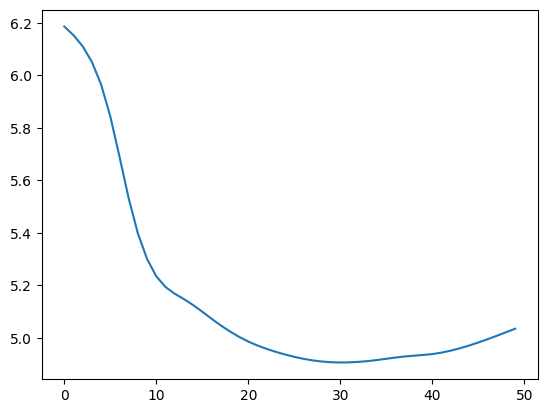

In [34]:
import matplotlib.pyplot as plt
plt.plot(range(model_nn.epoch), model_nn.loss_train)

C:\Users\Keun Ho Ryu\AppData\Local\Temp\ipykernel_13256\4213227160.py:82: RuntimeWarning: overflow encountered in exp
  return (np.exp(A)-np.exp(-A))/(np.exp(A)+np.exp(-A))
C:\Users\Keun Ho Ryu\AppData\Local\Temp\ipykernel_13256\4213227160.py:82: RuntimeWarning: invalid value encountered in divide
  return (np.exp(A)-np.exp(-A))/(np.exp(A)+np.exp(-A))


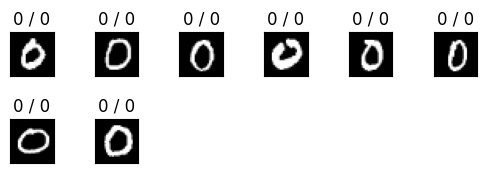

In [37]:
#visualize
y_pred = model_nn.predict(X_test)

num = 36 #
true_false = y_pred == y_test
false_list = np.where(true_false==True)[0].astype(int)
X_test = X_test*255.0

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_test[false_list[i]]))
    ax.imshow(X_test.reshape(-1,28,28)[false_list[i]], cmap='gray')
plt.show()